In [411]:
# Import the requested libraries
import numpy  as np
import math
import pandas as pd
from   sktime.forecasting.model_selection import temporal_train_test_split
from   sktime.forecasting.naive import NaiveForecaster
from   sktime.forecasting.base import ForecastingHorizon
from   sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_squared_error, mean_squared_percentage_error
from   sktime.forecasting.arima import AutoARIMA
from   sktime.forecasting.compose import make_reduction
from   sklearn.metrics import r2_score
from   statsmodels.tsa.seasonal import seasonal_decompose
from   statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import zipfile
import networkx as nx
import os
import joblib
import random
from   libpysal.weights import W
import geopandas as gpd
from   hyperopt import fmin, tpe, hp, Trials
from   hyperopt.pyll.base import scope

In [473]:
class DataWizard:

    MODEL_FOLDER = 'model'
    
    def __init__(self, file_path: str, random_seed:int = 69):

        self.file_path          = file_path
        self.dataframe          = pd.DataFrame()  # Initialize an empty DataFrame
        self.dataframe_testing  = pd.DataFrame()  # Initialize an empty DataFrame
        self.dataframe_training = pd.DataFrame()  # Initialize an empty DataFrame
        #self.RANDOM_SEED      = random_seed
        #Creating a file location for the models
        os.makedirs(DataWizard.MODEL_FOLDER, exist_ok=True)
        # Suppress warnings globally within the class instance
        warnings.simplefilter('ignore', UserWarning)  # Ignore user warnings
        warnings.simplefilter('ignore', FutureWarning)  # Ignore future warnings

    def load_data(self, first_date: str ='2017-04-01', end_date: str = '2019-12-31'):
        """
        Load data from a CSV file, apply dtype conversions, filter by date range, and store the dataframe.
    
        Args:
            first_date (str): Start date for filtering the data (default '2017-04-01').
            end_date (str): End date for filtering the data (default '2019-12-31').
        """
        try:
            df_tablon = pd.read_csv(self.file_path)            
            # dtype conversion
            df_tablon['periodo'] = pd.to_datetime(df_tablon['periodo'], format='mixed')
            # Identify columns to convert
            columns_to_convert = [col for col in df_tablon.columns if col not in ['periodo', 'departamento']]
            # Batch conversion to float
            df_tablon[columns_to_convert] = df_tablon[columns_to_convert].astype(float)
            #Date Range Filter
            df_tablon = df_tablon.query('periodo <= @end_date and periodo>=@first_date').\
                sort_values(['periodo', 'departamento'], ascending=True)
            self.dataframe = df_tablon
            
            print(f"Data loaded successfully from {self.file_path}")
        except Exception as e:
            print(f"Error loading data: {e}")

    def transform_data(self):
        '''
        The current funtion prepares the data for the ML Models.
            Update the periodo value to take the last day of the month - NaiveForecaster index format requirement.
            Select only the relevant features
        '''
        try:
            df_stats_detailed = self.dataframe[['periodo','departamento','cant_fallecidos_cancer']].copy()
            df_stats_detailed['periodo'] = df_stats_detailed['periodo'] + pd.offsets.MonthBegin(1) - pd.Timedelta(days=1)
            df_stats_detailed.set_index('periodo', inplace=True)

            print(f"Data formatted successfully from {self.file_path}")
            return df_stats_detailed
        except Exception as e:
            print(f"Error formatting data: {e}")            


    def split_data(self, test_size: int=4):
        '''
        The function splits the dataframe into training and testing set
        Args: test size (int): size or number of records of the testing set  
        '''
        try:
            df_stats_detailed = self.dataframe[['periodo','departamento','cant_fallecidos_cancer']].copy()
            df_stats_detailed['periodo'] = df_stats_detailed['periodo'] + pd.offsets.MonthBegin(1) - pd.Timedelta(days=1)
            df_stats_detailed.set_index('periodo', inplace=True)
            # substract only the training set
            index_testing = df_stats_detailed.index.unique()[-test_size:]
            self.dataframe_testing = df_stats_detailed.loc[index_testing,:]
            self.dataframe_training = df_stats_detailed.drop(index_testing)
        except Exception as e:
            print(f"Error loading data: {e}")

    def adfuller_evaluate_transform(self, df, test_size:int=4, tot_count:int=0, p_value_threshold:float=0.03):
        '''
        Apply the AdFuller test to assess how many transformation the time series demands
        to achieve non stationality with certin pvalue confidence interval.
        Args:
            df: Input dataframe
            test_size (int): number of records of the testing set
            tot_count (int): number of diff transformations required to achieve non stationality
            p_value_threshold (float): value to achieve the hypothesis test that the series is non stationay  
        '''

        df_output = pd.DataFrame(columns=['periodo','departamento', 'cant_fallecidos_cancer', 'number_transf'])
        
        #Generate only testing set for ADF eva
        
        df_train = df.drop(df.index.unique()[-test_size:])   
        state_list = df['departamento'].unique()

        # Loop over each 'departamento'
        for e in state_list:
            # Extract the subset of the dataframe for the current 'departamento'
            df_subset = df_train.loc[df_train['departamento'] == e]
            # Perform ADF test only in testing set
            adf_result = adfuller(df_subset.iloc[:, 1])
            p_value = adf_result[1]        
            # If p-value is greater than 0.03, perform differencing and call the function recursively
            if p_value >= p_value_threshold:
                tot_count += 1  # Increment transformation count
                # Perform differencing in the whole dataset
                df_temp = df[df['departamento']==e].iloc[:, 1].diff().dropna().to_frame()
                df_temp['departamento'] = e
                df_temp = df_temp.iloc[:, [1, 0]]
                
                # Call the function recursively without returning immediately
                df_transf = self.adfuller_evaluate_transform(df_temp, test_size, tot_count, p_value_threshold)            
                df_output = pd.concat([df_output, df_transf.reset_index()], ignore_index=True)
            else:

        
                df_temp = df[df['departamento']==e].iloc[:, 1].to_frame()
                df_temp['departamento'] = e
                df_temp = df_temp.iloc[:, [1, 0]]
                df_temp['number_transf']= tot_count            
                # Create a DataFrame for the detailed result
                df_output = pd.concat([df_output, df_temp.reset_index()], ignore_index=True)            
            tot_count=0    
        return df_output.set_index('periodo')
    
    def generate_transformation_summary(self, df, test_size:int=4, tot_count:int=0, p_value_threshold:float=0.03):
        '''
        Generate a summary result of the adfuller_evaluate_transform function by departamento
        Args:
            df: Input dataframe
            test_size (int): number of records of the testing set
            tot_count (int): number of diff transformations required to achieve non stationality
            p_value_threshold (float): value to achieve the hypothesis test that the series is non stationay  

        '''
        df_master = self.adfuller_evaluate_transform(df, test_size, tot_count, p_value_threshold)
        df_summary = df_master.\
            drop(columns=['cant_fallecidos_cancer']).\
            drop_duplicates(subset=['departamento','number_transf']).\
            reset_index(drop=True)
        return df_summary

    def decompress_df(self, df_temp, y_pred, n_transf=0):
        '''
        Generates a dataframe with the decompressed time series and the inferred predicted values
        Args:
            df_temp (pd.DataFrame): Dataframe in the transformed_data format - includes training and testing set
            y_pred  (pd.Series): Predicted values of the compressed data series
            n_transf (int): Number of transformations the compressed series possess   
        '''
        df = df_temp.copy()
        if n_transf==0:
            df['cant_fallecidos_cancer_predicted'] = np.nan
            df.iloc[-len(y_pred):, -1] = y_pred
            return df
        else:
            for i in range(n_transf):
                if i==0:
                    df[f'quantity_diff_{i+1}'] = df['cant_fallecidos_cancer'].diff()
                else:
                    df[f'quantity_diff_{i+1}'] = df[f'quantity_diff_{i}'].diff()

            df.iloc[-len(y_pred):, -n_transf:]=0
            df.iloc[-len(y_pred):, -1] = y_pred
            
            #display(df.tail(10))
            
            for i in range(1, n_transf):
                for j in range(len(y_pred),0,-1):  
                    df.iloc[-j, -1-i] = df.iloc[-j, -i] +df.iloc[-j-1, -i-1]
            
            #display(df.tail(10))

            df_append = df.iloc[-len(y_pred):,-n_transf].cumsum() + df.iloc[-len(y_pred)-1,-n_transf-1]
            df_append.name ='cant_fallecidos_cancer_predicted'

            #display(df_append.tail(10))
            
            df = pd.merge(df, df_append, how='left', on='periodo').\
                iloc[:,[0,1,-1]]
            # round y_pred value to the closest max integer: number of deaths is not decimal
            df.iloc[:,-1] = df.iloc[:,-1].apply(lambda e: np.ceil(e))
            
            return df    

    def plot_forecast(self, df, title = 'Monthly Forecast of Deaths:', x_label = 'Date', y_label = 'Number of Deaths' ): 
        """
        Plot the forecasted vs. real values of deaths over time and print performance metrics (R² and RMSE).

        Args:
            df (DataFrame): The DataFrame containing the actual and forecasted death data. The last column contains
                            forecasted values, and the second-to-last column contains real values.
            title (str): Title for the plot (default 'Monthly Forecast of Deaths:').
            x_label (str): Label for the x-axis (default 'Date').
            y_label (str): Label for the y-axis (default 'Number of Deaths').
        """


        y_test = df[~df.iloc[:,-1].isna()].iloc[:,-2]
        y_pred = df[~df.iloc[:,-1].isna()].iloc[:,-1]
        
        # Generate performance metrics
        
        r2 = r2_score(y_test.values, y_pred.values)
        rmse = mean_squared_error(y_test.values, y_pred.values, squared=False)

        print(f'R2 (R2): {r2:.2%}')
        print(f'RMSE: {(rmse)}')
        
        # Graph results with forecasted and real values
        
        train_index= df.index[:-len(y_test)]
        test_index= df.index[-len(y_test):]
        plt.figure(figsize=(10, 6))
        plt.plot(df.index, df.iloc[:,-2], label='Real Deaths', marker='o')
        plt.plot(test_index, y_pred, label='Forecasted Deaths', linestyle='--', marker='x')
        plt.axvline(train_index[-1], color='red', linestyle='--', label='Train/ Test Divide')

        # Añadir annotations to the series
        for i in range(len(y_test)):
            plt.text(test_index[i], y_test.iloc[i], f'{y_test.iloc[i]:.1f}', color='blue', ha='right')
            plt.text(test_index[i], y_pred.iloc[i], f'{y_pred.iloc[i]:.1f}', color='orange', ha='left')

        plt.legend()
        plt.title(title + f'{df.iloc[0,0]}')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.show()    

    def bys_model_optimizer(self, df_temp, threshold_ratio = 0.8, max_attempt:int = 6, test_size:int = 4):
        """
        Bayesian optimization for a NaiveForecaster model using Hyperopt. The function maximizes the R² 
        indicator of the "decompressed" time series 

        Args:
            df_temp (DataFrame): Input data containing the time series for a specific department.
            threshold_ratio (float): The threshold ratio for R² score to stop optimization. Default is 0.8.
            max_attempt (int): Maximum number of optimization attempts if a satisfactory model is not found. Default is 6.
            test_size (int): The size of the test set for splitting the time series. Default is 4.

        Returns:
            DataFrame: A DataFrame containing the optimized model's metrics (R², RMSE) and predictions.
        """        
        # Define your series and split it into training and testing sets
        s_department = df_temp['departamento'].unique()[0]  # Save global department
        series = df_temp.iloc[:, 1].reset_index(drop=True)  # Replace df_temp with your actual dataframe
        y_train, y_test = temporal_train_test_split(series, test_size=test_size)
        # Define original Dataframe
        df_original = self.transform_data().query('departamento==@s_department')

        
        fh = ForecastingHorizon(y_test.index, is_relative=False)

        # Define the search space for Hyperopt
        search_space = {
            'strategy': hp.choice('strategy', ['last', 'mean', 'drift']),
            'window_length': hp.choice('window_length', np.arange(1, len(y_train)+1, dtype=int)),
            'sp': hp.choice('sp', np.arange(1, len(y_train)+1, dtype=int))
        }

        # Define the objective function
        def objective(params):
            # Check if the restriction is violated
            if params['window_length'] <= params['sp']:
                return 1e6  # Large value to penalize invalid parameter combinations
            
            # Create the model with the current set of hyperparameters
            forecaster = NaiveForecaster(strategy=params['strategy'], window_length=params['window_length'], sp=params['sp'])
            
            # Fit the model to the training data
            forecaster.fit(y_train)
            
            # Make predictions
            y_pred = forecaster.predict(fh)
            
            # Decompress series to max R²
            df_obj = self.decompress_df(
                #original dataframe
                df_original,
                y_pred, 
                df_temp.iloc[0,-1]
            )

            #display(df_obj)
            r2 = r2_score(
                #real
                df_obj.iloc[-test_size:,-2],
                #predicted
                df_obj.iloc[-test_size:,-1] 
            )
            return -r2  # Since we want to maximize R², we minimize the negative value
        
        # Run the Hyperopt optimization
        #np.random.seed(self.RANDOM_SEED)  # For NumPy-based randomness
        #random.seed(self.RANDOM_SEED)     # For Python's random module

        trials = Trials()  # Store details of the optimization process
        best_result = None
        rerun=True
        attempt_count=0
        while rerun and attempt_count < max_attempt:
            #Each new seed per attempt        
            #np.random.seed(self.RANDOM_SEED+50*attempt_count)
            #random.seed(self.RANDOM_SEED+50*attempt_count)

            print(f'___attempt_count :{attempt_count}')
            best_params = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=1000, trials=trials)#, rstate= np.random.seed(self.RANDOM_SEED))
            best_loss   = trials.best_trial['result']['loss']
            if best_loss<=-threshold_ratio:
                rerun = False
                best_result = best_params
            else:                
                print(f'Unacceptable R² score encountered in attempt {attempt_count}. Rerunning optimization...')
            attempt_count+=1

        if attempt_count==max_attempt:
            print(f"Maximum attempts ({attempt_count}) reached. Using the best available model parameters.")
            best_result = best_params

        # Print the best parameters found
        print("Best Parameters:", best_result)

        # Convert Hyperopt output into usable strategy, window_length, and sp
        best_strategy = ['last', 'mean', 'drift'][best_result['strategy']]
        best_window_length = best_result['window_length']+1
        best_sp = best_result['sp']+1
        
        # Create and train the best model using the found parameters
        forecaster = NaiveForecaster(strategy=best_strategy, window_length=best_window_length, sp=best_sp)
        forecaster.fit(y_train)
        
        y_pred = forecaster.predict(fh)
        # Save the model
        # Define the model name and path
        #model_path = os.path.join(DataWizard.MODEL_FOLDER, 'naive_forecaster_model_'+s_department+'.pkl')
        # Save the trained model
        #joblib.dump(forecaster, model_path)
        #print(f"Model saved to {model_path}")    
        # Generate performance metrics

        #r2 = r2_score(y_test, y_pred)
        #rmse = mean_squared_error(y_test, y_pred, squared=False)

        #print(y_train, y_pred, sep='\n')

        # Decompress series to max R²
        df_obj = self.decompress_df(
            #original dataframe
            df_original,
            y_pred, 
            df_temp.iloc[0,-1]
        )

        #display(df_obj)
        r2 = r2_score(
            #real
            df_obj.iloc[-test_size:,-2],
            #predicted
            df_obj.iloc[-test_size:,-1] 
        )
        rmse = mean_squared_error(
            #real
            df_obj.iloc[-test_size:,-2],
            #predicted
            df_obj.iloc[-test_size:,-1]             
        )

        print(f'R2 (R2): {r2:.2%}')
        print(f'RMSE: {(rmse)}')
        df_metrics = pd.DataFrame({
            'Model': ['NaiveForecaster'], 
            'Department':[s_department],
            'R² Score': [r2], 
            'RMSE': [rmse],
            'number_transf':[df_temp.iloc[-1,-1]][0],
            'y_pred':[y_pred]
        })
        return df_metrics
    
    def model_fit_predict(self, df_test, threshold_ratio = 0.6, max_attempt:int = 6, test_size:int = 4):
        """
        Fit and predict multiple departments using Bayesian optimization on a NaiveForecaster model.

        Args:
            df_test (DataFrame): The input data containing time series for multiple departments.
            threshold_ratio (float): The R² score threshold to accept the model. Default is 0.6.
            max_attempt (int): Maximum number of attempts for optimization per department. Default is 6.
            test_size (int): The size of the test set for train-test split. Default is 4.

        Returns:
            dict: A dictionary containing:
                - 'summary': A DataFrame summarizing the R² and RMSE scores for each department.
                - 'detail': A DataFrame with the real and predicted values for each department.
        """        
        df_temp       = df_test.copy() 
        df_output     = pd.DataFrame(columns=['Model','Department', 'R² Score', 'RMSE','number_transf','y_pred'])
        df_decompress = pd.DataFrame(columns=['departamento','cant_fallecidos_cancer', 'cant_fallecidos_cancer_predicted'])    

        for e in df_temp['departamento'].unique():
            
            df_result = self.bys_model_optimizer(df_temp.loc[df_temp['departamento']==e], threshold_ratio, max_attempt, test_size)
            df_output = pd.concat([df_output, df_result], ignore_index=True).\
                sort_values(by=['R² Score'], ascending=False).\
                reset_index(drop=True)
                             
            df_result_decompress = self.decompress_df(
                #original dataframe
                self.transform_data().query('departamento==@e'),
                #predicted values 
                df_result['y_pred'][0], 
                #number of data transformations
                df_temp.loc[df_temp['departamento'] == e].iloc[:,-1].unique()[0]
            )
                        
            df_decompress = pd.concat([df_decompress, df_result_decompress], ignore_index=False)

        output = {
            'summary':df_output,
            'detail': df_decompress
        } 
        return output

    def show_data(self, num_rows: int = 5):
        """
        Display the first few rows of the dataframe stored in the object.

        Parameters:
        ----------
        num_rows : int, optional, default=5
            The number of rows to display from the top of the dataframe.
            By default, the function will display the first 5 rows.
        """
        display(self.dataframe.head(num_rows))  # Display the first few rows of the dataframe

In [481]:
path_tablon = '.\\data\\fpc_main_dataset.csv'
oTemp = DataWizard(path_tablon)
oTemp.load_data()
df_baseline= oTemp.adfuller_evaluate_transform(oTemp.transform_data(),p_value_threshold=0.003) 

Data loaded successfully from .\data\fpc_main_dataset.csv
Data formatted successfully from .\data\fpc_main_dataset.csv


In [482]:
dpto_code='PUNO'
df_query = df_baseline.query('departamento==@dpto_code')
df_query.tail(10)

,departamento,cant_fallecidos_cancer,number_transf
periodo,,,
2019-03-31,PUNO,13.0,1
2019-04-30,PUNO,-22.0,1
2019-05-31,PUNO,19.0,1
2019-06-30,PUNO,-13.0,1
2019-07-31,PUNO,-11.0,1
2019-08-31,PUNO,20.0,1
2019-09-30,PUNO,-3.0,1
2019-10-31,PUNO,3.0,1
2019-11-30,PUNO,-20.0,1


In [483]:
#df_detail = oTemp.model_fit_predict(df_baseline, threshold_ratio=0.8, max_attempt=4, test_size = 4)
df_detail = oTemp.model_fit_predict(df_query, threshold_ratio=0.6, max_attempt=6, test_size = 4)


Data formatted successfully from .\data\fpc_main_dataset.csv
___attempt_count :0
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 1000/1000 [00:32<00:00, 30.78trial/s, best loss: -0.7795844625112918]
Best Parameters: {'sp': 13, 'strategy': 1, 'window_length': 21}
R2 (R2): 77.96%
RMSE: 15.25
Data formatted successfully from .\data\fpc_main_dataset.csv


In [484]:
df_detail.keys()

dict_keys(['summary', 'detail'])

In [485]:
df_detail['summary']

,Model,Department,R² Score,RMSE,number_transf,y_pred
0,NaiveForecaster,PUNO,0.779584,15.25,1,28 -9.0 29 5.0 30 -16.0 31 23.0 Na...


In [488]:
df_detail['detail'].query('departamento==@dpto_code').tail(10)

,departamento,cant_fallecidos_cancer,cant_fallecidos_cancer_predicted
2019-03-31,PUNO,86.0,NaN
2019-04-30,PUNO,64.0,NaN
2019-05-31,PUNO,83.0,NaN
2019-06-30,PUNO,70.0,NaN
2019-07-31,PUNO,59.0,NaN
2019-08-31,PUNO,79.0,NaN
2019-09-30,PUNO,76.0,70.0
2019-10-31,PUNO,79.0,75.0
2019-11-30,PUNO,59.0,59.0
2019-12-31,PUNO,79.0,82.0


R2 (R2): 77.96%
RMSE: 15.25


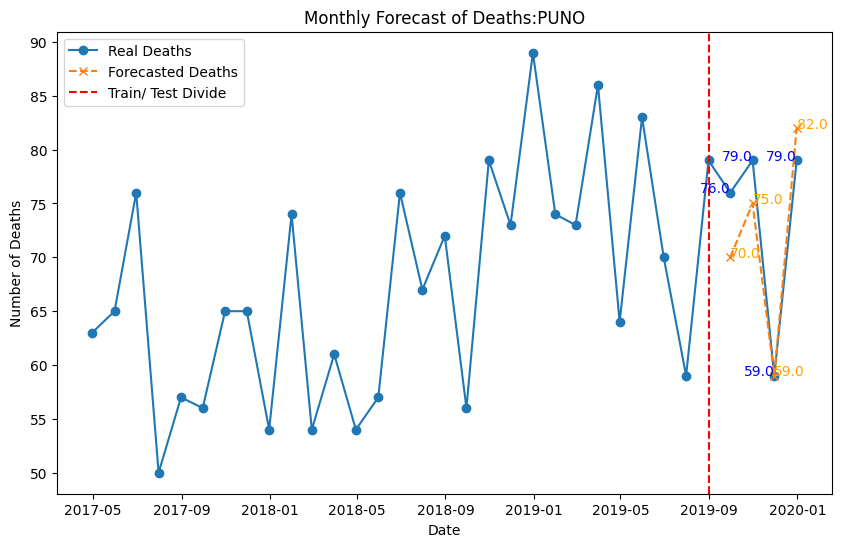

In [487]:
oTemp.plot_forecast(df_detail['detail'].query('departamento==@dpto_code'))
#oTemp.plot_forecast(df_detail['detail'].query('departamento=="AMAZONAS"'))